<div style="background:#F5F7FA; height:100px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Want to do more?</span><span style="border: 1px solid #3d70b2;padding: 15px;float:right;margin-right:40px; color:#3d70b2; "><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
<span style="color:#5A6872;"> Try out this notebook with your free trial of IBM Watson Studio.</span>
</div>


# The Unit Commitment Problem (UCP)

This tutorial includes everything you need to set up IBM Decision Optimization CPLEX Modeling for Python (DOcplex), build a Mathematical Programming model, and get its solution by solving the model on the cloud with IBM ILOG CPLEX Optimizer.

When you finish this tutorial, you'll have a foundational knowledge of _Prescriptive Analytics_.

>This notebook is part of <a href="https://rawgit.com/IBMDecisionOptimization/docplex-doc/master/docs/index.html" target="_blank" rel="noopener noreferrer">Prescriptive Analytics for Python</a>.

>It requires a valid subscription to **Decision Optimization on Cloud**. Try it for free <a href="https://developer.ibm.com/docloud" target="_blank" rel="noopener noreferrer">here</a>.

This notebook runs on Python 3.5 with Spark 2.1.

Table of contents:

-  [Describe the business problem](#Describe-the-business-problem)
*  [How decision optimization (prescriptive analytics) can help](#How--decision-optimization-can-help)
*  [Use decision optimization](#Use-decision-optimization)
    *  [Step 1: Download the library](#Step-1:-Download-the-library)
    *  [Step 2: Set up the engines](#Step-2:-Set-up-the-prescriptive-engine)
    -  [Step 3: Model the Data](#Step-3:-Model-the-data)
    *  [Step 4: Prepare the data](#Step-4:-Prepare-the-data)
    -  [Step 5: Set up the prescriptive model](#Step-5:-Set-up-the-prescriptive-model)
        * [Define the decision variables](#Define-the-decision-variables)
        * [Express the business constraints](#Express-the-business-constraints)
        * [Express the objective](#Express-the-objective)
        * [Solve with the Decision Optimization solve service](#Solve-with-the-Decision-Optimization-solve-service)
    *  [Step 6: Investigate the solution and run an example analysis](#Step-6:-Investigate-the-solution-and-then-run-an-example-analysis)
*  [Summary](#Summary)

****

## Describe the business problem

* The Model estimates the lower cost of generating electricity within a given plan. 
Depending on the demand for electricity, we turn on or off units that generate power and which have operational properties and costs.

* The Unit Commitment Problem answers the question "Which power generators should I run at which times and at what level in order to satisfy the demand for electricity?". This  model  helps users to find not only a feasible answer to the question, but one that also optimizes its solution to meet as many of the electricity company's overall goals as possible. 


## How  decision optimization can help

* Prescriptive analytics (decision optimization) technology recommends actions that are based on desired outcomes.  It takes into account specific scenarios, resources, and knowledge of past and current events. With this insight, your organization can make better decisions and have greater control of business outcomes.  

* Prescriptive analytics is the next step on the path to insight-based actions. It creates value through synergy with predictive analytics, which analyzes data to predict future outcomes.  

* Prescriptive analytics takes that insight to the next level by suggesting the optimal way to handle that future situation. Organizations that can act fast in dynamic conditions and make superior decisions in uncertain environments gain a strong competitive advantage.  
<br/>

<u>With prescriptive analytics, you can:</u> 

* Automate the complex decisions and trade-offs to better manage your limited resources.
* Take advantage of a future opportunity or mitigate a future risk.
* Proactively update recommendations based on changing events.
* Meet operational goals, increase customer loyalty, prevent threats and fraud, and optimize business processes.

## Checking minimum requirements
This notebook uses some features of *pandas* that are available in version 0.17.1 or above.

In [1]:
import pip
REQUIRED_MINIMUM_PANDAS_VERSION = '0.17.1'
d = {pkg.key : pkg.version for pkg in pip.get_installed_distributions()}
try:
    assert d['pandas'] >= REQUIRED_MINIMUM_PANDAS_VERSION
except:
    raise Exception("Version " + REQUIRED_MINIMUM_PANDAS_VERSION + " or above of Pandas is required to run this notebook")

## Use decision optimization

### Step 1: Download the library

Run the following code to the install the Decision Optimization CPLEX Modeling library.  The *DOcplex* library contains the two modeling packages, Mathematical Programming (*docplex.mp*) and Constraint Programming (*docplex.cp*).

In [2]:
import sys
try:
    import docplex.mp
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install docplex 
    else:
        !pip install --user docplex      

### Step 2: Set up the prescriptive engine

* Subscribe to the <a href="https://developer.ibm.com/docloud" target="_blank" rel="noopener noreferrer">Decision Optimization on Cloud solve service</a>.
* Get the service URL and your personal API key (Client_id) and enter your credentials here:

In [3]:
url = "" # ENTER YOUR URL HERE
key = "" # ENTER YOUR KEY (Client_id) HERE

### Step 3: Model the data
#### Load data from a *pandas* DataFrame

Data for the Unit Commitment Problem is provided as a *pandas* DataFrame.
For a standalone notebook, we provide the raw data as Python collections,
but real data could be loaded
from an Excel sheet, also using *pandas*.

In [4]:
import pandas as pd
from pandas import DataFrame, Series

# make matplotlib plots appear inside the notebook
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 11, 5 ############################ <-Use this to change the plot

Update the configuration of notebook so that display matches browser window width.

In [5]:
from IPython.core.display import HTML
HTML("<style>.container { width:100%; }</style>")

#### Available energy technologies

The following *df_energy* DataFrame stores CO<sub>2</sub> cost information, indexed by energy type.

In [6]:
energies = ["coal", "gas", "diesel", "wind"]
df_energy = DataFrame({"co2_cost": [30, 5, 15, 0]}, index=energies)

# Display the 'df_energy' Data Frame
df_energy

,co2_cost
coal,30
gas,5
diesel,15
wind,0


The following *df_units* DataFrame stores common elements for units of a given technology.

In [7]:
all_units = ["coal1", "coal2", 
             "gas1", "gas2", "gas3", "gas4", 
             "diesel1", "diesel2", "diesel3", "diesel4"]
             
ucp_raw_unit_data = {
        "energy": ["coal", "coal", "gas", "gas", "gas", "gas", "diesel", "diesel", "diesel", "diesel"],
        "initial" : [400, 350, 205, 52, 155, 150, 78, 76, 0, 0],
        "min_gen": [100, 140, 78, 52, 54.25, 39, 17.4, 15.2, 4, 2.4],
        "max_gen": [425, 365, 220, 210, 165, 158, 90, 87, 20, 12],
        "operating_max_gen": [400, 350, 205, 197, 155, 150, 78, 76, 20, 12],
        "min_uptime": [15, 15, 6, 5, 5, 4, 3, 3, 1, 1],
        "min_downtime":[9, 8, 7, 4, 3, 2, 2, 2, 1, 1],
        "ramp_up":   [212, 150, 101.2, 94.8, 58, 50, 40, 60, 20, 12],
        "ramp_down": [183, 198, 95.6, 101.7, 77.5, 60, 24, 45, 20, 12],
        "start_cost": [5000, 4550, 1320, 1291, 1280, 1105, 560, 554, 300, 250],
        "fixed_cost": [208.61, 117.37, 174.12, 172.75, 95.353, 144.52, 54.417, 54.551, 79.638, 16.259],
        "variable_cost": [22.536, 31.985, 70.5, 69, 32.146, 54.84, 40.222, 40.522, 116.33, 76.642],
        }

df_units = DataFrame(ucp_raw_unit_data, index=all_units)

# Display the 'df_units' Data Frame
df_units

,energy,fixed_cost,initial,max_gen,min_downtime,min_gen,min_uptime,operating_max_gen,ramp_down,ramp_up,start_cost,variable_cost
coal1,coal,208.610,400,425,9,100.00,15,400,183.0,212.0,5000,22.536
coal2,coal,117.370,350,365,8,140.00,15,350,198.0,150.0,4550,31.985
gas1,gas,174.120,205,220,7,78.00,6,205,95.6,101.2,1320,70.500
gas2,gas,172.750,52,210,4,52.00,5,197,101.7,94.8,1291,69.000
gas3,gas,95.353,155,165,3,54.25,5,155,77.5,58.0,1280,32.146
gas4,gas,144.520,150,158,2,39.00,4,150,60.0,50.0,1105,54.840
diesel1,diesel,54.417,78,90,2,17.40,3,78,24.0,40.0,560,40.222
diesel2,diesel,54.551,76,87,2,15.20,3,76,45.0,60.0,554,40.522
diesel3,diesel,79.638,0,20,1,4.00,1,20,20.0,20.0,300,116.330
diesel4,diesel,16.259,0,12,1,2.40,1,12,12.0,12.0,250,76.642


### Step 4: Prepare the data

The *pandas* *merge* operation is used to create a join between the *df_units* and *df_energy* DataFrames. Here, the join is performed based on the *'energy'* column of *df_units* and index column of *df_energy*.

By default, *merge* performs an *inner* join. That is, the resulting DataFrame is based on the **intersection** of keys from both input DataFrames.

In [8]:
# Add a derived co2-cost column by merging with df_energies
# Use energy key from units and index from energy dataframe
df_up = pd.merge(df_units, df_energy, left_on="energy", right_index=True)
df_up.index.names=['units']

# Display first rows of new 'df_up' Data Frame
df_up.head()

,energy,fixed_cost,initial,max_gen,min_downtime,min_gen,min_uptime,operating_max_gen,ramp_down,ramp_up,start_cost,variable_cost,co2_cost
units,,,,,,,,,,,,,
coal1,coal,208.610,400,425,9,100.00,15,400,183.0,212.0,5000,22.536,30
coal2,coal,117.370,350,365,8,140.00,15,350,198.0,150.0,4550,31.985,30
gas1,gas,174.120,205,220,7,78.00,6,205,95.6,101.2,1320,70.500,5
gas2,gas,172.750,52,210,4,52.00,5,197,101.7,94.8,1291,69.000,5
gas3,gas,95.353,155,165,3,54.25,5,155,77.5,58.0,1280,32.146,5


The demand is stored as a *pandas* _Series_ indexed from 1 to the number of periods.

nb periods = 192


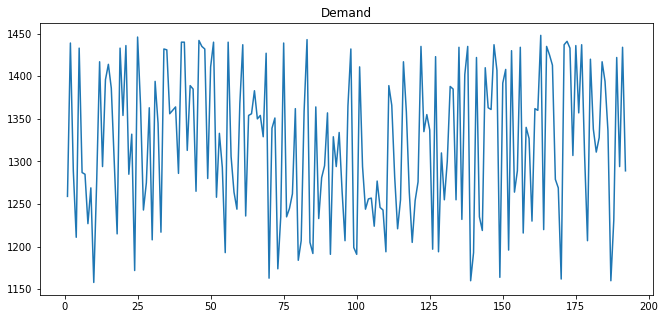

In [9]:
raw_demand = [1259.0, 1439.0, 1289.0, 1211.0, 1433.0, 1287.0, 1285.0, 1227.0, 1269.0, 1158.0, 1277.0, 1417.0, 1294.0, 1396.0, 1414.0, 1386.0,
              1302.0, 1215.0, 1433.0, 1354.0, 1436.0, 1285.0, 1332.0, 1172.0, 1446.0, 1367.0, 1243.0, 1275.0, 1363.0, 1208.0, 1394.0, 1345.0, 
              1217.0, 1432.0, 1431.0, 1356.0, 1360.0, 1364.0, 1286.0, 1440.0, 1440.0, 1313.0, 1389.0, 1385.0, 1265.0, 1442.0, 1435.0, 1432.0, 
              1280.0, 1411.0, 1440.0, 1258.0, 1333.0, 1293.0, 1193.0, 1440.0, 1306.0, 1264.0, 1244.0, 1368.0, 1437.0, 1236.0, 1354.0, 1356.0, 
              1383.0, 1350.0, 1354.0, 1329.0, 1427.0, 1163.0, 1339.0, 1351.0, 1174.0, 1235.0, 1439.0, 1235.0, 1245.0, 1262.0, 1362.0, 1184.0, 
              1207.0, 1359.0, 1443.0, 1205.0, 1192.0, 1364.0, 1233.0, 1281.0, 1295.0, 1357.0, 1191.0, 1329.0, 1294.0, 1334.0, 1265.0, 1207.0, 
              1365.0, 1432.0, 1199.0, 1191.0, 1411.0, 1294.0, 1244.0, 1256.0, 1257.0, 1224.0, 1277.0, 1246.0, 1243.0, 1194.0, 1389.0, 1366.0, 
              1282.0, 1221.0, 1255.0, 1417.0, 1358.0, 1264.0, 1205.0, 1254.0, 1276.0, 1435.0, 1335.0, 1355.0, 1337.0, 1197.0, 1423.0, 1194.0, 
              1310.0, 1255.0, 1300.0, 1388.0, 1385.0, 1255.0, 1434.0, 1232.0, 1402.0, 1435.0, 1160.0, 1193.0, 1422.0, 1235.0, 1219.0, 1410.0, 
              1363.0, 1361.0, 1437.0, 1407.0, 1164.0, 1392.0, 1408.0, 1196.0, 1430.0, 1264.0, 1289.0, 1434.0, 1216.0, 1340.0, 1327.0, 1230.0, 
              1362.0, 1360.0, 1448.0, 1220.0, 1435.0, 1425.0, 1413.0, 1279.0, 1269.0, 1162.0, 1437.0, 1441.0, 1433.0, 1307.0, 1436.0, 1357.0, 
              1437.0, 1308.0, 1207.0, 1420.0, 1338.0, 1311.0, 1328.0, 1417.0, 1394.0, 1336.0, 1160.0, 1231.0, 1422.0, 1294.0, 1434.0, 1289.0]
nb_periods = len(raw_demand)
print("nb periods = {}".format(nb_periods))

demand = Series(raw_demand, index = range(1, nb_periods+1))

# plot demand
demand.plot(title="Demand")

### Step 5: Set up the prescriptive model

In [10]:
from docplex.mp.environment import Environment
env = Environment()
env.print_information()

* system is: Linux 64bit
* Python is present, version is 3.5.4
* docplex is present, version is (2, 4, 61)
* CPLEX wrapper is not available


#### Create the DOcplex model
The model contains all the business constraints and defines the objective.

In [11]:
from docplex.mp.model import Model

ucpm = Model("ucp")

#### Define the decision variables

Decision variables are:

- The variable *in_use[u,t]* is 1 if and only if unit _u_ is working at period _t_.
- The variable *turn_on[u,t]* is 1 if and only if unit _u_ is in production at period _t_.
- The variable *turn_off[u,t]* is 1 if unit _u_ is switched off at period _t_.
- The variable *production[u,t]* is a continuous variables representing the production of energy for unit _u_ at period _t_.

In [12]:
units = all_units
# periods range from 1 to nb_periods included
periods = range(1, nb_periods+1)

# in use[u,t] is true iff unit u is in production at period t
in_use = ucpm.binary_var_matrix(keys1=units, keys2=periods, name="in_use")

# true if unit u is turned on at period t
turn_on = ucpm.binary_var_matrix(keys1=units, keys2=periods, name="turn_on")

# true if unit u is switched off at period t
# modeled as a continuous 0-1 variable, more on this later
turn_off = ucpm.continuous_var_matrix(keys1=units, keys2=periods, lb=0, ub=1, name="turn_off")

# production of energy for unit u at period t
production = ucpm.continuous_var_matrix(keys1=units, keys2=periods, name="p")

# at this stage we have defined the decision variables.
ucpm.print_information()

Model: ucp
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 0
   - linear=0
 - parameters: defaults


In [13]:
# Organize all decision variables in a DataFrame indexed by 'units' and 'periods'
df_decision_vars = DataFrame({'in_use': in_use, 'turn_on': turn_on, 'turn_off': turn_off, 'production': production})
# Set index names
df_decision_vars.index.names=['units', 'periods']

# Display first few rows of 'df_decision_vars' DataFrame
df_decision_vars.head()

in_use production          turn_off          turn_on
units periods                                                              
coal1 1        in_use_coal1_1  p_coal1_1  turn_off_coal1_1  turn_on_coal1_1
      2        in_use_coal1_2  p_coal1_2  turn_off_coal1_2  turn_on_coal1_2
      3        in_use_coal1_3  p_coal1_3  turn_off_coal1_3  turn_on_coal1_3
      4        in_use_coal1_4  p_coal1_4  turn_off_coal1_4  turn_on_coal1_4
      5        in_use_coal1_5  p_coal1_5  turn_off_coal1_5  turn_on_coal1_5

#### Express the business constraints

##### Linking in-use status to production

Whenever the unit is in use, the production must be within the minimum and maximum generation.


In [14]:
# Create a join between 'df_decision_vars' and 'df_up' Data Frames based on common index id (ie: 'units')
# In 'df_up', one keeps only relevant columns: 'min_gen' and 'max_gen'
df_join_decision_vars_up = df_decision_vars.join(df_up[['min_gen', 'max_gen']], how='inner')

# Display first few rows of joined Data Frames
df_join_decision_vars_up.head()

in_use production          turn_off          turn_on  \
units periods                                                                 
coal1 1        in_use_coal1_1  p_coal1_1  turn_off_coal1_1  turn_on_coal1_1   
      2        in_use_coal1_2  p_coal1_2  turn_off_coal1_2  turn_on_coal1_2   
      3        in_use_coal1_3  p_coal1_3  turn_off_coal1_3  turn_on_coal1_3   
      4        in_use_coal1_4  p_coal1_4  turn_off_coal1_4  turn_on_coal1_4   
      5        in_use_coal1_5  p_coal1_5  turn_off_coal1_5  turn_on_coal1_5   

               min_gen  max_gen  
units periods                    
coal1 1          100.0      425  
      2          100.0      425  
      3          100.0      425  
      4          100.0      425  
      5          100.0      425

In [15]:
import pandas as pb
print(pd.__version__)


0.22.0


In [16]:
# When in use, the production level is constrained to be between min and max generation.
for item in df_join_decision_vars_up.itertuples(index=False):
    ucpm += (item.production <= item.max_gen * item.in_use)
    ucpm += (item.production >= item.min_gen * item.in_use)

##### Initial state
The solution must take into account the initial state. The initial state of use of the unit is determined by its initial production level.

In [17]:
# Initial state
# If initial production is nonzero, then period #1 is not a turn_on
# else turn_on equals in_use
# Dual logic is implemented for turn_off
for u in units:
    if df_up.initial[u] > 0:
        # if u is already running, not starting up
        ucpm.add_constraint(turn_on[u, 1] == 0)
        # turnoff iff not in use
        ucpm.add_constraint(turn_off[u, 1] + in_use[u, 1] == 1)
    else:
        # turn on at 1 iff in use at 1
        ucpm.add_constraint(turn_on[u, 1] == in_use[u, 1])
        # already off, not switched off at t==1
        ucpm.add_constraint(turn_off[u, 1] == 0)
ucpm.print_information()

Model: ucp
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 3860
   - linear=3860
 - parameters: defaults


##### Ramp-up / ramp-down constraint
Variations of the production level over time in a unit is constrained by a ramp-up / ramp-down process.

We use the *pandas* *groupby* operation to collect all decision variables for each unit in separate series. Then, we iterate over units to post constraints enforcing the ramp-up / ramp-down process by setting upper bounds on the variation of the production level for consecutive periods.

In [18]:
# Use groupby operation to process each unit
for unit, r in df_decision_vars.groupby(level='units'):
    u_ramp_up = df_up.ramp_up[unit]
    u_ramp_down = df_up.ramp_down[unit]
    u_initial = df_up.initial[unit]
    # Initial ramp up/down
    # Note that r.production is a Series that can be indexed as an array (ie: first item index = 0)
    ucpm.add_constraint(r.production[0] - u_initial <= u_ramp_up)
    ucpm.add_constraint(u_initial - r.production[0] <= u_ramp_down)
    for (p_curr, p_next) in zip(r.production, r.production[1:]):
        ucpm.add_constraint(p_next - p_curr <= u_ramp_up)
        ucpm.add_constraint(p_curr - p_next <= u_ramp_down)

ucpm.print_information()

Model: ucp
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 7700
   - linear=7700
 - parameters: defaults


##### Turn on / turn off
The following constraints determine when a unit is turned on or off.

We use the same *pandas* *groupby* operation as in the previous constraint to iterate over the sequence of decision variables for each unit.

In [19]:
# Turn_on, turn_off
# Use groupby operation to process each unit
for unit, r in df_decision_vars.groupby(level='units'):
    for (in_use_curr, in_use_next, turn_on_next, turn_off_next) in zip(r.in_use, r.in_use[1:], r.turn_on[1:], r.turn_off[1:]):
        # if unit is off at time t and on at time t+1, then it was turned on at time t+1
        ucpm.add_constraint(in_use_next - in_use_curr <= turn_on_next)

        # if unit is on at time t and time t+1, then it was not turned on at time t+1
        # mdl.add_constraint(in_use_next + in_use_curr + turn_on_next <= 2)

        # if unit is on at time t and off at time t+1, then it was turned off at time t+1
        ucpm.add_constraint(in_use_curr - in_use_next + turn_on_next == turn_off_next)
ucpm.print_information()        

Model: ucp
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 11520
   - linear=11520
 - parameters: defaults


##### Minimum uptime and downtime
When a unit is turned on, it cannot be turned off before a *minimum uptime*. Conversely, when a unit is turned off, it cannot be turned on again before a *minimum downtime*.

Again, let's use the same *pandas* *groupby* operation to implement this constraint for each unit.

In [20]:
# Minimum uptime, downtime
for unit, r in df_decision_vars.groupby(level='units'):
    min_uptime   = df_up.min_uptime[unit]
    min_downtime = df_up.min_downtime[unit]
    # Note that r.turn_on and r.in_use are Series that can be indexed as arrays (ie: first item index = 0)
    for t in range(min_uptime, nb_periods):
        ctname = "min_up_{0!s}_{1}".format(*r.index[t])
        ucpm.add_constraint(ucpm.sum(r.turn_on[(t - min_uptime) + 1:t + 1]) <= r.in_use[t], ctname)

    for t in range(min_downtime, nb_periods):
        ctname = "min_down_{0!s}_{1}".format(*r.index[t])
        ucpm.add_constraint(ucpm.sum(r.turn_off[(t - min_downtime) + 1:t + 1]) <= 1 - r.in_use[t], ctname)


##### Demand constraint
Total production level must be equal or higher than demand on any period.

This time, the *pandas* operation *groupby* is performed on *"periods"* since we have to iterate over the list of all units for each period.

In [21]:
# Enforcing demand
# we use a >= here to be more robust, 
# objective will ensure  we produce efficiently
for period, r in df_decision_vars.groupby(level='periods'):
    total_demand = demand[period]
    ctname = "ct_meet_demand_%d" % period
    ucpm.add_constraint(ucpm.sum(r.production) >= total_demand, ctname) 

#### Express the objective

Operating the different units incur different costs: fixed cost, variable cost, startup cost, co2 cost.

In a first step, we define the objective as a non-weighted sum of all these costs.

The following *pandas* *join* operation groups all the data to calculate the objective in a single DataFrame.

In [22]:
# Create a join between 'df_decision_vars' and 'df_up' Data Frames based on common index ids (ie: 'units')
# In 'df_up', one keeps only relevant columns: 'fixed_cost', 'variable_cost', 'start_cost' and 'co2_cost'
df_join_obj = df_decision_vars.join(
    df_up[['fixed_cost', 'variable_cost', 'start_cost', 'co2_cost']], how='inner')

# Display first few rows of joined Data Frame
df_join_obj.head()

in_use production          turn_off          turn_on  \
units periods                                                                 
coal1 1        in_use_coal1_1  p_coal1_1  turn_off_coal1_1  turn_on_coal1_1   
      2        in_use_coal1_2  p_coal1_2  turn_off_coal1_2  turn_on_coal1_2   
      3        in_use_coal1_3  p_coal1_3  turn_off_coal1_3  turn_on_coal1_3   
      4        in_use_coal1_4  p_coal1_4  turn_off_coal1_4  turn_on_coal1_4   
      5        in_use_coal1_5  p_coal1_5  turn_off_coal1_5  turn_on_coal1_5   

               fixed_cost  variable_cost  start_cost  co2_cost  
units periods                                                   
coal1 1            208.61         22.536        5000        30  
      2            208.61         22.536        5000        30  
      3            208.61         22.536        5000        30  
      4            208.61         22.536        5000        30  
      5            208.61         22.536        5000        30

In [23]:
# objective
total_fixed_cost = ucpm.sum(df_join_obj.in_use * df_join_obj.fixed_cost)
total_variable_cost = ucpm.sum(df_join_obj.production * df_join_obj.variable_cost)
total_startup_cost = ucpm.sum(df_join_obj.turn_on * df_join_obj.start_cost)
total_co2_cost = ucpm.sum(df_join_obj.production * df_join_obj.co2_cost)
total_economic_cost = total_fixed_cost + total_variable_cost + total_startup_cost

total_nb_used = ucpm.sum(df_decision_vars.in_use)
total_nb_starts = ucpm.sum(df_decision_vars.turn_on)

# store expression kpis to retrieve them later.
ucpm.add_kpi(total_fixed_cost   , "Total Fixed Cost")
ucpm.add_kpi(total_variable_cost, "Total Variable Cost")
ucpm.add_kpi(total_startup_cost , "Total Startup Cost")
ucpm.add_kpi(total_economic_cost, "Total Economic Cost")
ucpm.add_kpi(total_co2_cost     , "Total CO2 Cost")
ucpm.add_kpi(total_nb_used, "Total #used")
ucpm.add_kpi(total_nb_starts, "Total #starts")

# minimize sum of all costs
ucpm.minimize(total_fixed_cost + total_variable_cost + total_startup_cost + total_co2_cost)

#### Solve with the Decision Optimization solve service

Solve the model on the cloud. 

In [24]:
ucpm.print_information()

Model: ucp
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 15455
   - linear=15455
 - parameters: defaults


In [25]:
assert ucpm.solve(url=url, key=key), "!!! Solve of the model fails"

In [26]:
ucpm.report()

* model ucp solved with objective = 14213082.064
*  KPI: Total Fixed Cost    = 161025.131
*  KPI: Total Variable Cost = 8865900.433
*  KPI: Total Startup Cost  = 2832.000
*  KPI: Total Economic Cost = 9029757.564
*  KPI: Total CO2 Cost      = 5183324.500
*  KPI: Total #used         = 1335.000
*  KPI: Total #starts       = 3.000


### Step 6: Investigate the solution and then run an example analysis

Now let's store the results in a new *pandas* DataFrame.

For convenience, the different figures are organized into pivot tables with *periods* as row index and *units* as columns. The *pandas* *unstack* operation does this for us.

In [27]:
df_prods = df_decision_vars.production.apply(lambda v: v.solution_value).unstack(level='units')
df_used = df_decision_vars.in_use.apply(lambda v: v.solution_value).unstack(level='units')
df_started = df_decision_vars.turn_on.apply(lambda v: v.solution_value).unstack(level='units')

# Display the first few rows of the pivoted 'production' data
df_prods.head()

units,coal1,coal2,diesel1,diesel2,diesel3,diesel4,gas1,gas2,gas3,gas4
periods,,,,,,,,,,
1,425.0,215.0,90.0,87.0,0.0,0.0,109.4,52.0,165.0,115.6
2,425.0,365.0,90.0,87.0,0.0,0.0,78.0,71.0,165.0,158.0
3,425.0,312.0,90.0,87.0,0.0,0.0,0.0,52.0,165.0,158.0
4,425.0,234.0,90.0,87.0,0.0,0.0,0.0,52.0,165.0,158.0
5,425.0,365.0,90.0,87.0,0.0,0.0,0.0,143.0,165.0,158.0


From these raw DataFrame results, we can compute _derived_ results.
For example, for a given unit and period, the _reserve_ r(u,t) is defined as
the unit's maximum generation minus the current production.

In [28]:
df_spins = DataFrame(df_up.max_gen.to_dict(), index=periods) - df_prods

# Display the first few rows of the 'df_spins' Data Frame, representing the reserve for each unit, over time
df_spins.head()

,coal1,coal2,diesel1,diesel2,diesel3,diesel4,gas1,gas2,gas3,gas4
1,-2.273737e-13,1.500000e+02,-2.842171e-14,-2.842171e-14,20.0,12.0,110.6,158.0,-5.684342e-14,4.240000e+01
2,-1.136868e-13,-5.684342e-14,-1.421085e-14,0.000000e+00,20.0,12.0,142.0,139.0,0.000000e+00,-2.842171e-14
3,-1.136868e-13,5.300000e+01,-1.421085e-14,0.000000e+00,20.0,12.0,220.0,158.0,-2.842171e-14,0.000000e+00
4,-1.136868e-13,1.310000e+02,0.000000e+00,0.000000e+00,20.0,12.0,220.0,158.0,-2.842171e-14,0.000000e+00
5,-1.136868e-13,-5.684342e-14,0.000000e+00,0.000000e+00,20.0,12.0,220.0,67.0,-2.842171e-14,-2.842171e-14


Let's plot the evolution of the reserves for the *"coal2"* unit:

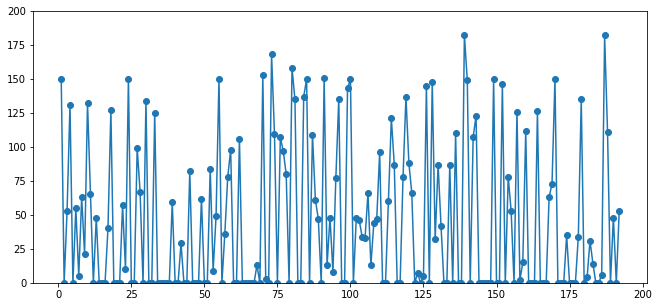

In [29]:
df_spins.coal2.plot(style='o-', ylim=[0,200])

Now we want to sum all unit reserves to compute the _global_ spinning reserve.
We need to sum all columns of the DataFrame to get an aggregated time series. We use the *pandas* **sum** method
with axis=1 (for rows).

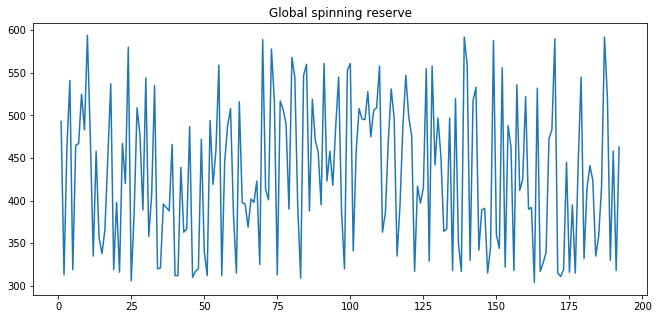

In [30]:
global_spin = df_spins.sum(axis=1)
global_spin.plot(title="Global spinning reserve")

#### Number of plants online by period

The total number of plants online at each period t is the sum of in_use variables for all units at this period.
Again, we use the *pandas* sum with axis=1 (for rows) to sum over all units.

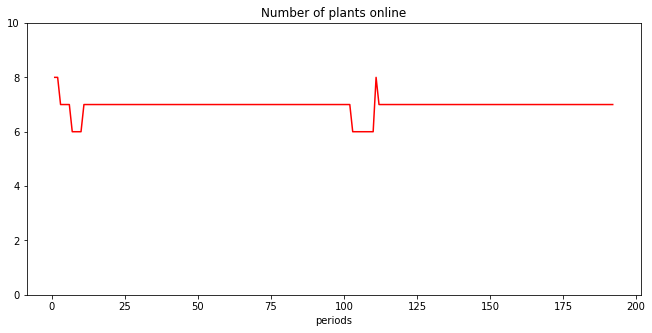

In [31]:
df_used.sum(axis=1).plot(title="Number of plants online", kind='line', style="r-", ylim=[0, len(units)])

#### Costs by period

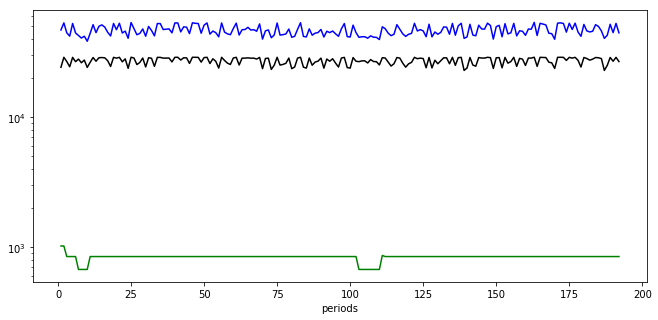

In [32]:
# extract unit cost data
all_costs = ["fixed_cost", "variable_cost", "start_cost", "co2_cost"]
df_costs = df_up[all_costs]

running_cost = df_used * df_costs.fixed_cost
startup_cost = df_started * df_costs.start_cost
variable_cost = df_prods * df_costs.variable_cost
co2_cost = df_prods * df_costs.co2_cost
total_cost = running_cost + startup_cost + variable_cost + co2_cost

running_cost.sum(axis=1).plot(style='g')
startup_cost.sum(axis=1).plot(style='r')
variable_cost.sum(axis=1).plot(style='b',logy=True)
co2_cost.sum(axis=1).plot(style='k')

#### Cost breakdown by unit and by energy

Text(0.5,1,'total cost by energy type')

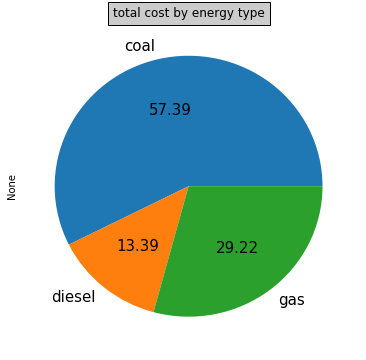

In [33]:
# Calculate sum by column (by default, axis = 0) to get total cost for each unit
cost_by_unit = total_cost.sum()

# Create a dictionary storing energy type for each unit, from the corresponding pandas Series
unit_energies = df_up.energy.to_dict()

# Group cost by unit type and plot total cost by energy type in a pie chart
gb = cost_by_unit.groupby(unit_energies)
# gb.sum().plot(kind='pie')
gb.sum().plot.pie(figsize=(6, 6),autopct='%.2f',fontsize=15)

plt.title('total cost by energy type', bbox={'facecolor':'0.8', 'pad':5})

### Arbitration between CO<sub>2</sub> cost and economic cost

Economic cost and CO<sub>2</sub> cost usually push in opposite directions.
In the above discussion, we have minimized the raw sum of economic cost and CO<sub>2</sub> cost, without weights.
But how good could we be on CO<sub>2</sub>, regardless of economic constraints? 
To know this, let's solve again with CO<sub>2</sub> cost as the only objective.


In [34]:
# first retrieve the co2 and economic kpis
co2_kpi = ucpm.kpi_by_name("co2") # does a name matching
eco_kpi = ucpm.kpi_by_name("eco")
prev_co2_cost = co2_kpi.compute()
prev_eco_cost = eco_kpi.compute()
print("* current CO2 cost is: {}".format(prev_co2_cost))
print("* current $$$ cost is: {}".format(prev_eco_cost))
# now set the objective
old_objective = ucpm.objective_expr # save it
ucpm.minimize(co2_kpi.as_expression())

* current CO2 cost is: 5183324.5
* current $$$ cost is: 9029757.56390015


In [35]:
assert ucpm.solve(url=url, key=key), "Solve failed"

In [36]:
min_co2_cost = ucpm.objective_value
min_co2_eco_cost = eco_kpi.compute()
print("* absolute minimum for CO2 cost is {}".format(min_co2_cost))
print("* at this point $$$ cost is {}".format(min_co2_eco_cost))

* absolute minimum for CO2 cost is 3398912.0
* at this point $$$ cost is 12465167.074200232


As expected, we get a significantly lower CO<sub>2</sub> cost when minimized alone, at the price of a higher economic cost.

We could do a similar analysis for economic cost to estimate the absolute minimum of
the economic cost, regardless of CO<sub>2</sub> cost.

In [37]:
# minimize only economic cost
ucpm.minimize(eco_kpi.as_expression())

In [38]:
assert ucpm.solve(url=url, key=key), "Solve failed"

In [39]:
min_eco_cost = ucpm.objective_value
min_eco_co2_cost = co2_kpi.compute()
print("* absolute minimum for $$$ cost is {}".format(min_eco_cost))
print("* at this point CO2 cost is {}".format(min_eco_co2_cost))

* absolute minimum for $$$ cost is 8886788.647400003
* at this point CO2 cost is 5375788.000000001


Again, the absolute minimum for economic cost is lower than the figure we obtained in the original model where we minimized the _sum_ of economic and CO<sub>2</sub> costs, but here we significantly increase the CO<sub>2</sub>.

But what happens in between these two extreme points?

To investigate, we will divide the interval of CO<sub>2</sub> cost values in smaller intervals, add an upper limit on CO<sub>2</sub>,
and minimize economic cost with this constraint. This will give us a Pareto optimal point with at most this CO<sub>2</sub> value.

To avoid adding many constraints, we add only one constraint with an extra variable, and we change only the upper bound
of this CO<sub>2</sub> limit variable between successive solves.

Then we iterate (with a fixed number of iterations) and collect the cost values. 

In [40]:
# add extra variable
co2_limit = ucpm.continuous_var(lb=0)
# add a named constraint which limits total co2 cost to this variable:
max_co2_ctname = "ct_max_co2"
co2_ct = ucpm.add_constraint(co2_kpi.as_expression() <= co2_limit, max_co2_ctname)     

In [41]:
co2min = min_co2_cost
co2max = min_eco_co2_cost
def explore_ucp(nb_iters, eps=1e-5):

    step = (co2max-co2min)/float(nb_iters)
    co2_ubs = [co2min + k * step for k in range(nb_iters+1)]

    # ensure we minimize eco
    ucpm.minimize(eco_kpi.as_expression())
    all_co2s = []
    all_ecos = []
    for k in range(nb_iters+1):
        co2_ub = co2min + k * step
        print(" iteration #{0} co2_ub={1}".format(k, co2_ub))
        co2_limit.ub = co2_ub + eps
        assert ucpm.solve(url=url, key=key) is not None, "Solve failed"
        cur_co2 = co2_kpi.compute()
        cur_eco = eco_kpi.compute()
        all_co2s.append(cur_co2)
        all_ecos.append(cur_eco)
    return all_co2s, all_ecos

In [42]:
#explore the co2/eco frontier in 50 points
co2s, ecos = explore_ucp(nb_iters=50)

 iteration #0 co2_ub=3398912.0
 iteration #1 co2_ub=3438449.52
 iteration #2 co2_ub=3477987.04
 iteration #3 co2_ub=3517524.56
 iteration #4 co2_ub=3557062.08
 iteration #5 co2_ub=3596599.6
 iteration #6 co2_ub=3636137.12
 iteration #7 co2_ub=3675674.64
 iteration #8 co2_ub=3715212.16
 iteration #9 co2_ub=3754749.68
 iteration #10 co2_ub=3794287.2
 iteration #11 co2_ub=3833824.72
 iteration #12 co2_ub=3873362.24
 iteration #13 co2_ub=3912899.7600000002
 iteration #14 co2_ub=3952437.2800000003
 iteration #15 co2_ub=3991974.8000000003
 iteration #16 co2_ub=4031512.3200000003
 iteration #17 co2_ub=4071049.8400000003
 iteration #18 co2_ub=4110587.3600000003
 iteration #19 co2_ub=4150124.8800000004
 iteration #20 co2_ub=4189662.4000000004
 iteration #21 co2_ub=4229199.92
 iteration #22 co2_ub=4268737.44
 iteration #23 co2_ub=4308274.960000001
 iteration #24 co2_ub=4347812.48
 iteration #25 co2_ub=4387350.0
 iteration #26 co2_ub=4426887.5200000005
 iteration #27 co2_ub=4466425.040000001
 ite

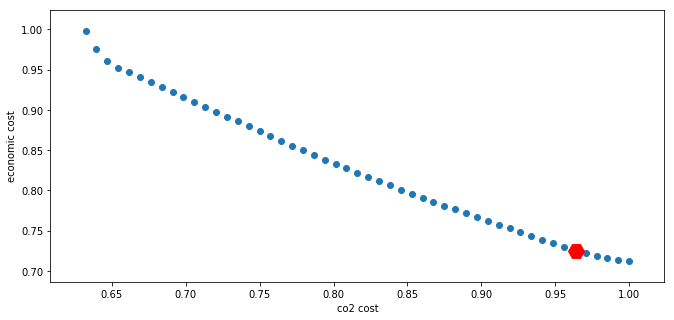

In [43]:
# normalize all values by dividing by their maximum
eco_max = min_co2_eco_cost
nxs = [c / co2max for c in co2s]
nys = [e / eco_max for e in ecos]
# plot a scatter chart of x=co2, y=costs
plt.scatter(nxs, nys)
# plot as one point
plt.plot(prev_co2_cost/co2max, prev_eco_cost/eco_max, "rH", markersize=16)
plt.xlabel("co2 cost")
plt.ylabel("economic cost")
plt.show()

This figure demonstrates that the result obtained in the initial model clearly favored
economic cost over CO<sub>2</sub> cost: CO<sub>2</sub> cost is well above 95% of its maximum value.

## Summary

You learned how to set up and use IBM Decision Optimization CPLEX Modeling for Python to formulate a Mathematical Programming model and solve it with IBM Decision Optimization on Cloud.

## Author

<b>Vincent Beraudier</b> is Software Architect and Program Manager for Prescriptive Analytics and Decision Optimization in IBM Analytics. With IBM and ILOG for more than 16 years, he has been responsible for optimization model development tools: OPL and DOcplex. OPL, the Optimization Programming Language, provides a natural mathematical description of optimization models. DOcplex, IBM's CPLEX modeling for Python offering, is an open source project that aims at leveraging the scientific ecosystem of Python and Jupyter/Zeppeling Notebooks. It can solve Optimization Mathematical Programming models with CPLEX cloud service (DOcplexcloud) or with CPLEX local solver, without any code change.

## References
* <a href="https://rawgit.com/IBMDecisionOptimization/docplex-doc/master/docs/index.html" target="_blank" rel="noopener noreferrer">CPLEX Modeling for Python documentation</a>
* <a href="https://developer.ibm.com/docloud/" target="_blank" rel="noopener noreferrer">Decision Optimization on Cloud</a>
* Need help with DOcplex or to report a bug? Please go <a href="https://developer.ibm.com/answers/smartspace/docloud" target="_blank" rel="noopener noreferrer">here</a>.
* Contact us at dofeedback@wwpdl.vnet.ibm.com.

Copyright © IBM 2017, 2018. This notebook and its source code are released under the terms of the MIT License.